In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)
%matplotlib inline

/home/itachi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
test1 = pd.read_csv('test1.csv')
test9 = pd.read_csv('test9.csv')
train1 = pd.read_csv('train1.csv')
train9 = pd.read_csv('train9.csv')
hero_data = pd.read_csv('hero_data.csv')

In [3]:
hero_data.head()

,hero_id,primary_attr,attack_type,roles,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,base_agility,base_intelligence,strength_gain,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate
0,1,agi,Melee,Carry:Escape:Nuker,200,1.50,75,0.9,-1.0,25,27,31,22,22,12,1.3,2.8,1.8,150,0,1.45,310,0.5
1,2,str,Melee,Initiator:Durable:Disabler:Jungler,200,4.25,75,0.9,-1.0,25,24,28,25,20,18,2.8,2.2,1.6,150,900,1.70,290,0.6
2,3,int,Ranged,Support:Disabler:Nuker:Durable,200,1.50,75,0.9,1.0,25,37,43,23,23,23,2.4,2.4,2.4,400,900,1.70,310,0.6
3,4,agi,Melee,Carry:Disabler:Jungler:Nuker:Initiator,200,1.50,75,0.9,0.0,25,33,39,23,24,18,2.7,3.0,1.7,150,900,1.70,285,0.5
4,5,int,Ranged,Support:Disabler:Nuker:Jungler,200,1.50,75,0.9,-1.0,25,19,25,16,16,16,2.0,1.6,2.9,600,900,1.70,275,0.5


# Data Preprocessing

In [4]:
# Combine user and hero data
train9_data = pd.merge(train9, hero_data, on='hero_id').sort_values('user_id').reset_index(drop=True)
train1_data = pd.merge(train1, hero_data, on='hero_id').sort_values('user_id').reset_index(drop=True)
test1_data = pd.merge(test1, hero_data, on='hero_id').sort_values('user_id').reset_index(drop=True)
test9_data = pd.merge(test9, hero_data, on='hero_id').sort_values('user_id').reset_index(drop=True)

In [5]:
train9_data.head()

,user_id,hero_id,id,num_games,num_wins,kda_ratio,primary_attr,attack_type,roles,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,base_agility,base_intelligence,strength_gain,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate
0,1,74,1_74,304,185,3743.699732,int,Ranged,Carry:Nuker:Disabler:Escape:Pusher,200,1.50,75,0.9,-1.0,25,19,25,16,14,16,2.2,1.9,4.0,600,900,1.7,280,0.5
1,1,39,1_39,203,135,5094.621514,int,Ranged,Carry:Nuker:Escape,200,1.50,75,0.9,-1.0,25,21,29,16,18,24,2.0,2.0,2.5,550,1500,1.5,295,0.5
2,1,106,1_106,158,106,4619.212963,agi,Melee,Carry:Escape:Nuker:Disabler:Initiator,200,2.00,75,0.9,-2.0,25,30,34,19,22,20,2.1,1.8,1.8,150,900,1.7,305,0.5
3,1,2,1_2,157,94,2871.627907,str,Melee,Initiator:Durable:Disabler:Jungler,200,4.25,75,0.9,-1.0,25,24,28,25,20,18,2.8,2.2,1.6,150,900,1.7,290,0.6
4,1,46,1_46,154,103,3533.333333,agi,Ranged,Carry:Escape,200,1.50,75,0.9,1.0,25,30,36,18,23,20,2.4,2.3,2.0,140,900,1.7,300,0.7


In [6]:
train9_data.describe(include='all')

,user_id,hero_id,id,num_games,num_wins,kda_ratio,primary_attr,attack_type,roles,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,base_agility,base_intelligence,strength_gain,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate
count,18846.000000,18846.000000,18846,18846.000000,18846.000000,18846.000000,18846,18846,18846,18846.0,18846.000000,18846.0,1.884600e+04,18846.000000,18846.000000,18846.000000,18846.000000,18846.000000,18846.000000,18846.000000,18846.00000,18846.000000,18846.000000,18846.000000,18846.000000,18846.000000,18846.000000,18846.000000
unique,NaN,NaN,18569,NaN,NaN,NaN,3,2,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2658_14,NaN,NaN,NaN,agi,Ranged,Carry:Nuker:Disabler:Escape:Pusher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,2,NaN,NaN,NaN,7463,9961,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1488.840974,49.286957,NaN,188.120344,106.459036,3543.462003,NaN,NaN,NaN,200.0,1.699379,75.0,9.000000e-01,-0.156214,24.960204,24.124801,31.853231,19.540539,18.429004,19.094025,2.36815,2.009877,2.153250,345.139022,837.448265,1.674644,296.740157,0.616245
std,856.144028,34.674544,NaN,224.166666,132.167024,1081.195070,NaN,NaN,NaN,0.0,0.552141,0.0,1.986242e-13,1.583337,0.771616,7.297071,7.501991,3.338325,4.327545,4.510319,0.53086,0.660002,0.698238,199.238999,437.004559,0.095884,12.243780,0.151899
min,1.000000,1.000000,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN,200.0,1.000000,75.0,9.000000e-01,-3.000000,10.000000,4.000000,8.000000,14.000000,0.000000,12.000000,1.30000,0.000000,1.000000,140.000000,0.000000,1.300000,270.000000,0.500000
25%,752.000000,14.000000,NaN,76.000000,42.000000,2841.265936,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,-1.000000,25.000000,20.000000,27.000000,17.000000,15.000000,16.000000,2.00000,1.500000,1.650000,150.000000,900.000000,1.700000,290.000000,0.500000
50%,1480.500000,46.000000,NaN,138.000000,77.000000,3403.463637,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,-1.000000,25.000000,24.000000,32.000000,19.000000,18.000000,18.000000,2.20000,1.900000,2.000000,330.000000,900.000000,1.700000,295.000000,0.600000
75%,2233.000000,76.000000,NaN,228.000000,128.000000,4073.493596,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,1.000000,25.000000,28.000000,36.000000,22.000000,22.000000,23.000000,2.70000,2.400000,2.500000,550.000000,1100.000000,1.700000,305.000000,0.700000


In [7]:
train1_data.describe(include='all')

,user_id,hero_id,id,num_games,num_wins,kda_ratio,primary_attr,attack_type,roles,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,base_agility,base_intelligence,strength_gain,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate
count,2094.000000,2094.000000,2094,2094.000000,2094.000000,2094.000000,2094,2094,2094,2094.0,2094.000000,2094.0,2.094000e+03,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000
unique,NaN,NaN,2094,NaN,NaN,NaN,3,2,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2466_25,NaN,NaN,NaN,agi,Ranged,Carry:Nuker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,NaN,NaN,NaN,892,1127,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1488.840974,48.229226,NaN,167.324737,93.691022,3549.577823,NaN,NaN,NaN,200.0,1.702603,75.0,9.000000e-01,-0.171203,24.957020,24.315664,32.039160,19.362464,18.578797,19.217765,2.327101,2.030683,2.142813,349.481853,844.603629,1.672206,297.187202,0.617144
std,856.325810,35.134741,NaN,114.403209,63.559871,1007.010635,NaN,NaN,NaN,0.0,0.546613,0.0,3.287045e-14,1.633730,0.801972,7.460690,7.764227,3.282516,4.342509,4.544661,0.526609,0.667481,0.655186,199.078938,444.853122,0.098417,12.217816,0.154746
min,1.000000,1.000000,NaN,1.000000,0.000000,1286.968265,NaN,NaN,NaN,200.0,1.000000,75.0,9.000000e-01,-3.000000,10.000000,4.000000,8.000000,14.000000,0.000000,12.000000,1.300000,0.000000,1.000000,140.000000,0.000000,1.300000,270.000000,0.500000
25%,752.250000,14.000000,NaN,84.000000,47.000000,2875.381989,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,-1.000000,25.000000,21.000000,27.000000,17.000000,15.000000,16.000000,2.000000,1.500000,1.650000,150.000000,900.000000,1.700000,290.000000,0.500000
50%,1480.500000,41.000000,NaN,146.000000,82.000000,3419.950213,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,-1.000000,25.000000,24.000000,32.000000,19.000000,18.000000,18.000000,2.200000,1.900000,2.000000,350.000000,900.000000,1.700000,295.000000,0.600000
75%,2232.750000,77.000000,NaN,230.000000,126.000000,4089.720280,NaN,NaN,NaN,200.0,1.750000,75.0,9.000000e-01,1.000000,25.000000,28.000000,36.000000,22.000000,22.000000,23.000000,2.600000,2.500000,2.500000,550.000000,1100.000000,1.700000,305.000000,0.700000


In [8]:
test9_data.describe(include='all')

,user_id,hero_id,id,num_games,num_wins,kda_ratio,primary_attr,attack_type,roles,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,base_agility,base_intelligence,strength_gain,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate
count,8082.000000,8082.000000,8082,8082.000000,8082.000000,8082.000000,8082,8082,8082,8082.0,8082.000000,8082.0,8.082000e+03,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000
unique,NaN,NaN,7987,NaN,NaN,NaN,3,2,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2538_11,NaN,NaN,NaN,agi,Ranged,Carry:Nuker:Disabler:Escape:Pusher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,2,NaN,NaN,NaN,3158,4312,449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1514.359688,49.324548,NaN,192.425142,108.604801,3498.124948,NaN,NaN,NaN,200.0,1.707622,75.0,9.000000e-01,-0.172296,24.948033,24.005073,31.707993,19.524004,18.354863,19.138085,2.370632,2.007003,2.163864,348.811557,843.782480,1.673967,296.623361,0.618764
std,880.967122,34.788928,NaN,203.825158,117.814486,985.831478,NaN,NaN,NaN,0.0,0.564036,0.0,1.227983e-13,1.556800,0.881422,7.239318,7.514494,3.328298,4.307024,4.493088,0.530382,0.653936,0.698684,199.777785,437.797587,0.096137,12.205453,0.153861
min,3.000000,1.000000,NaN,1.000000,0.000000,142.857143,NaN,NaN,NaN,200.0,1.000000,75.0,9.000000e-01,-3.000000,10.000000,4.000000,8.000000,14.000000,0.000000,12.000000,1.300000,0.000000,1.000000,140.000000,0.000000,1.300000,270.000000,0.500000
25%,736.000000,14.000000,NaN,86.000000,47.000000,2804.193865,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,-1.000000,25.000000,19.000000,26.000000,17.000000,15.000000,16.000000,2.000000,1.500000,1.650000,150.000000,900.000000,1.700000,290.000000,0.500000
50%,1528.000000,44.000000,NaN,146.000000,81.000000,3374.324083,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,-1.000000,25.000000,23.000000,32.000000,19.000000,18.000000,18.000000,2.200000,1.900000,2.000000,350.000000,900.000000,1.700000,295.000000,0.600000
75%,2272.000000,76.000000,NaN,234.000000,131.000000,4036.212253,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,1.000000,25.000000,27.000000,36.000000,22.000000,22.000000,23.000000,2.700000,2.400000,2.500000,550.000000,1100.000000,1.700000,305.000000,0.700000


In [9]:
test1_data.describe(include='all')

,user_id,hero_id,id,num_games,primary_attr,attack_type,roles,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,base_agility,base_intelligence,strength_gain,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate
count,898.000000,898.000000,898,898.000000,898,898,898,898.0,898.000000,898.0,8.980000e+02,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000
unique,NaN,NaN,898,NaN,3,2,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,120_97,NaN,agi,Ranged,Carry:Nuker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,NaN,360,484,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1514.359688,49.287305,NaN,189.510022,NaN,NaN,NaN,200.0,1.723552,75.0,9.000000e-01,-0.153675,24.933185,23.724944,31.695991,19.491091,18.384187,19.198218,2.361359,2.008241,2.150612,349.938753,847.271715,1.680067,296.787305,0.617428
std,881.403514,34.488262,NaN,202.581116,NaN,NaN,NaN,0.0,0.589824,0.0,1.432986e-14,1.568322,0.999437,6.912663,7.344221,3.330617,4.301934,4.602447,0.513952,0.660153,0.695580,198.063286,438.277343,0.094605,12.062009,0.156590
min,3.000000,1.000000,NaN,2.000000,NaN,NaN,NaN,200.0,1.000000,75.0,9.000000e-01,-3.000000,10.000000,4.000000,8.000000,14.000000,0.000000,12.000000,1.300000,0.000000,1.000000,140.000000,0.000000,1.400000,270.000000,0.500000
25%,736.250000,14.000000,NaN,89.000000,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,-1.000000,25.000000,19.000000,27.000000,17.000000,14.000000,16.000000,2.000000,1.500000,1.650000,150.000000,900.000000,1.700000,290.000000,0.500000
50%,1528.000000,44.000000,NaN,147.000000,NaN,NaN,NaN,200.0,1.500000,75.0,9.000000e-01,-1.000000,25.000000,23.000000,32.000000,19.000000,18.000000,18.000000,2.200000,1.900000,2.000000,350.000000,900.000000,1.700000,295.000000,0.600000
75%,2271.250000,76.000000,NaN,222.000000,NaN,NaN,NaN,200.0,1.750000,75.0,9.000000e-01,1.000000,25.000000,27.000000,36.000000,22.000000,22.000000,24.000000,2.700000,2.400000,2.500000,550.000000,1100.000000,1.700000,305.000000,0.700000


In [10]:
# remove features
train9_data.drop(['id', 'num_wins', 'base_health', 'base_mana'], axis=1, inplace=True)
train1_data.drop(['id', 'num_wins', 'base_health', 'base_mana'], axis=1, inplace=True)

test9_data.drop(['id', 'num_wins', 'base_health', 'base_mana'], axis=1, inplace=True)
test1_data.drop(['id', 'base_health', 'base_mana'], axis=1, inplace=True)

In [11]:
# label encode
train9_data.primary_attr.replace(['int', 'agi', 'str'], [1, 2, 3], inplace=True)
train9_data.attack_type.replace(['Ranged', 'Melee'], [1, 0], inplace=True)
train1_data.primary_attr.replace(['int', 'agi', 'str'], [1, 2, 3], inplace=True)
train1_data.attack_type.replace(['Ranged', 'Melee'], [1, 0], inplace=True)

test9_data.primary_attr.replace(['int', 'agi', 'str'], [1, 2, 3], inplace=True)
test9_data.attack_type.replace(['Ranged', 'Melee'], [1, 0], inplace=True)
test1_data.primary_attr.replace(['int', 'agi', 'str'], [1, 2, 3], inplace=True)
test1_data.attack_type.replace(['Ranged', 'Melee'], [1, 0], inplace=True)

In [12]:
# spliting roles column-values into dummy variables
data = train9_data['roles'].str.get_dummies(sep=':')
train9_f = pd.concat([train9_data, data], axis=1)
train9_f.drop('roles', axis=1, inplace=True)

In [13]:
data = train1_data['roles'].str.get_dummies(sep=':')
train1_f = pd.concat([train1_data, data], axis=1)
train1_f.drop('roles', axis=1, inplace=True)

In [14]:
data = test9_data['roles'].str.get_dummies(sep=':')
test9_f = pd.concat([test9_data, data], axis=1)
test9_f.drop('roles', axis=1, inplace=True)

In [15]:
data = test1_data['roles'].str.get_dummies(sep=':')
test1_f = pd.concat([test1_data, data], axis=1)
test1_f.drop('roles', axis=1, inplace=True)

In [16]:
train1_f.head()

,user_id,hero_id,num_games,kda_ratio,primary_attr,attack_type,base_health_regen,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,base_agility,base_intelligence,strength_gain,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support
0,1,41,201,3731.707317,2,0,2.00,0.9,0.0,25,33,39,23,23,15,2.1,2.8,1.5,150,900,1.7,295,1.0,1,1,1,1,1,0,0,0,0
1,2,17,427,2922.058381,1,1,1.50,0.9,2.0,25,22,32,19,22,24,1.8,1.5,3.0,480,1100,1.7,285,0.8,1,1,0,1,1,0,1,0,0
2,5,106,240,5116.682739,2,0,2.00,0.9,-2.0,25,30,34,19,22,20,2.1,1.8,1.8,150,900,1.7,305,0.5,1,1,0,1,1,0,1,0,0
3,6,65,206,4131.553861,1,1,3.25,0.9,0.0,25,14,18,23,15,24,2.7,1.5,2.5,375,900,1.7,290,1.0,0,1,0,1,1,1,0,0,0
4,7,69,697,2474.469306,3,0,1.50,0.9,-1.0,25,27,43,26,11,13,3.5,0.9,2.1,150,900,2.0,290,0.5,1,1,1,0,1,0,1,0,0


# EDA

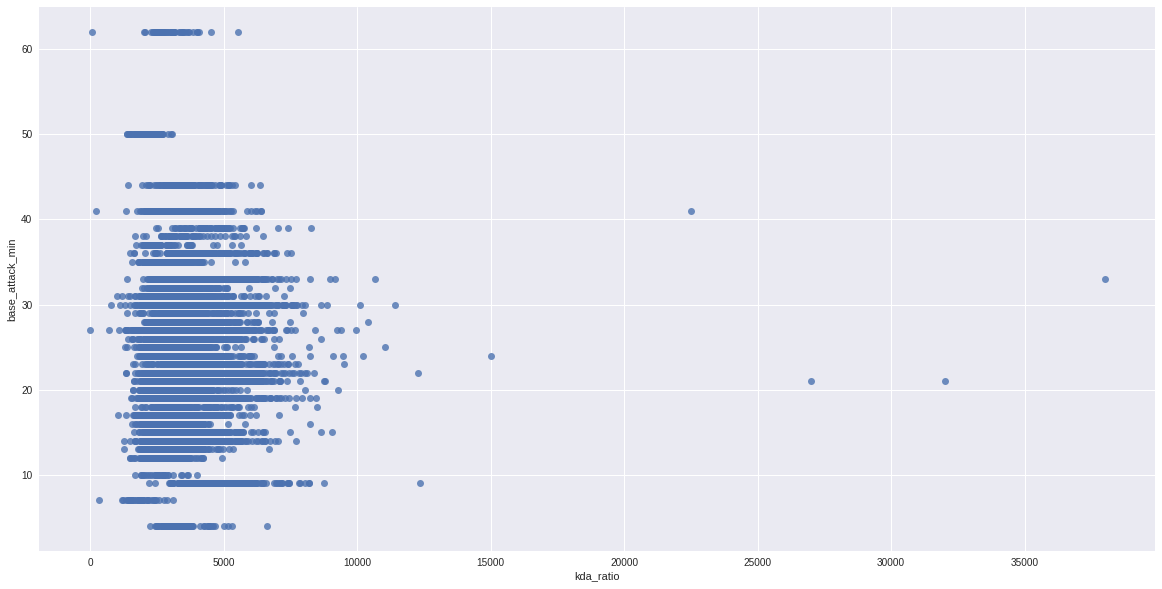

In [17]:
# Scatter plot
plt.figure(figsize=(20,10))
sns.regplot(x="kda_ratio", y="base_attack_min", data=train9_data, fit_reg=False)

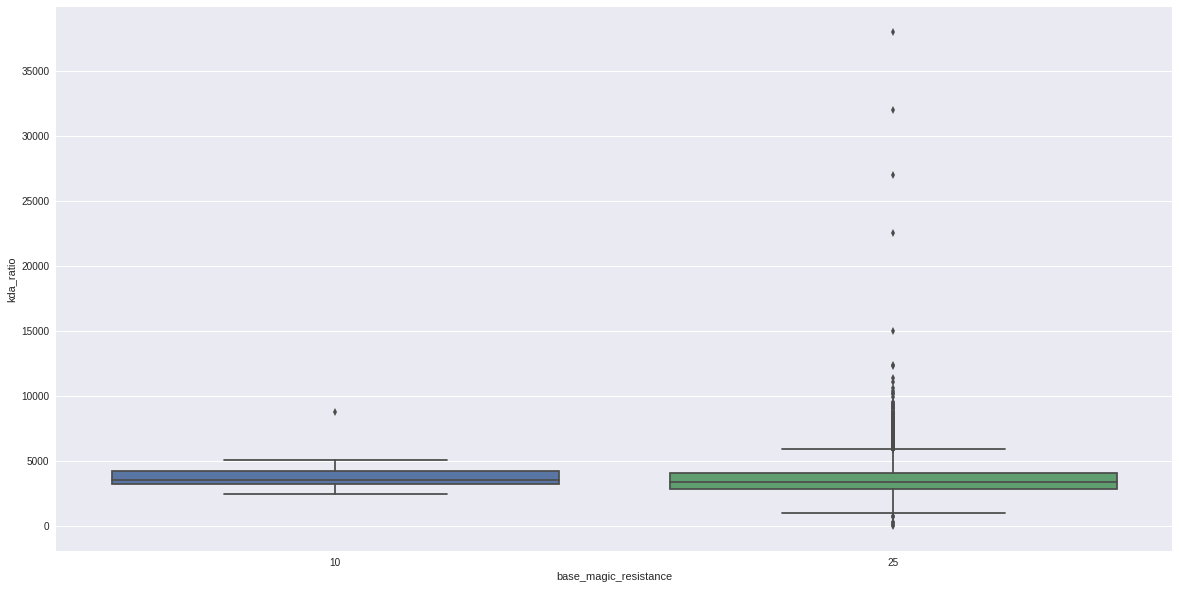

In [18]:
# boxplot
# as we can see there are 5 (kda_ratio > 15000) outliers, we can remove them. It may improve our model
plt.figure(figsize=(20,10))
sns.boxplot(x="base_magic_resistance", y="kda_ratio", data=train9_data)

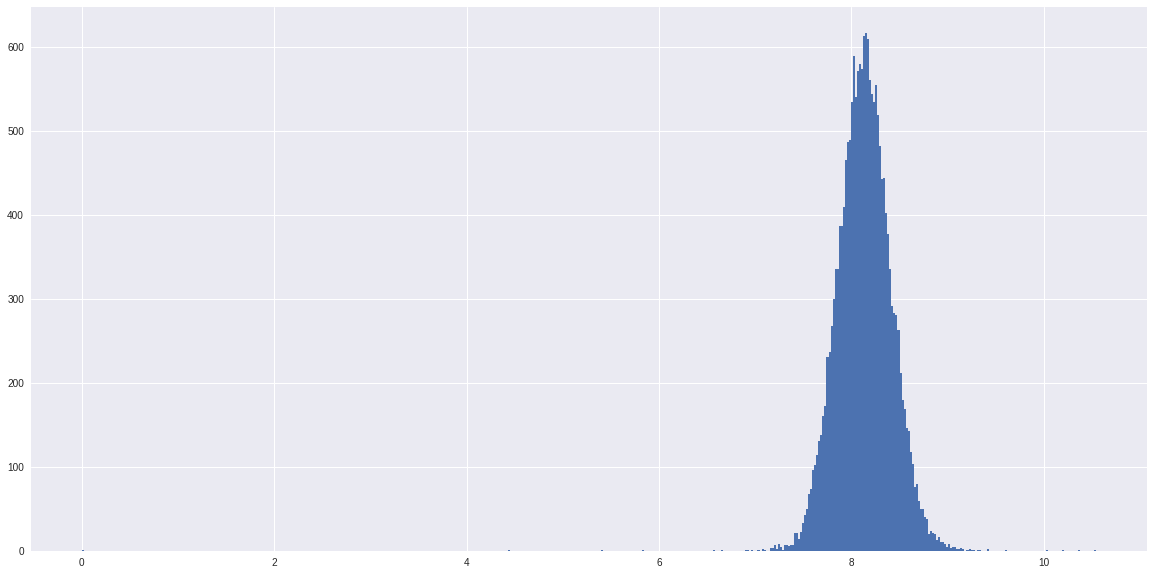

In [19]:
# log transformation on kde_ratio
plt.figure(figsize=(20,10))
plt.hist(np.log(1+train9_data['kda_ratio']), bins=500)
plt.show()

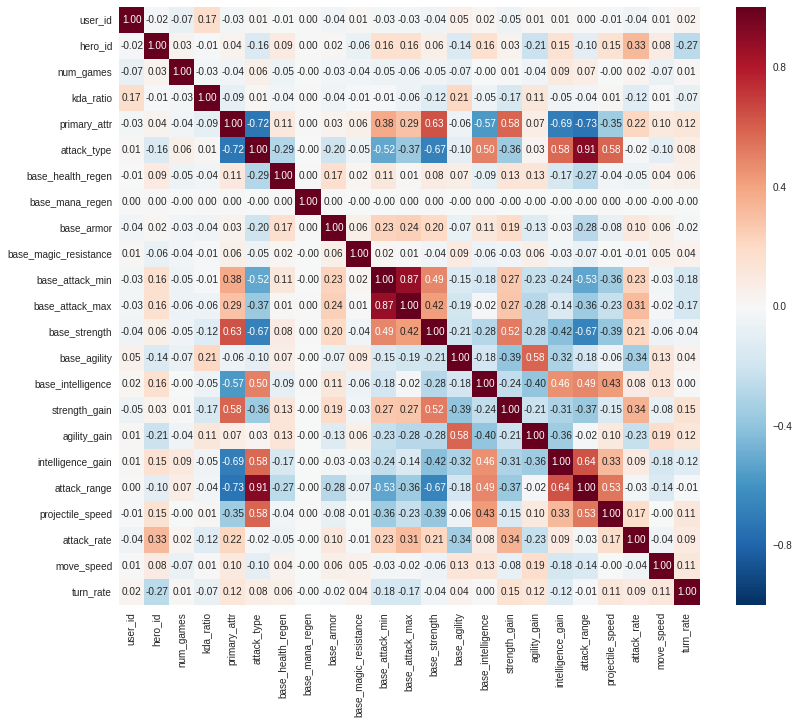

In [20]:
corr = train9_data.corr()
f, ax = plt.subplots(figsize=(13, 11))
sns.heatmap(corr, annot=True, fmt=".2f")

In [21]:
test1_f.describe(include='all')

,user_id,hero_id,num_games,primary_attr,attack_type,base_health_regen,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,base_agility,base_intelligence,strength_gain,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,8.980000e+02,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000
mean,1514.359688,49.287305,189.510022,1.870824,0.538976,1.723552,9.000000e-01,-0.153675,24.933185,23.724944,31.695991,19.491091,18.384187,19.198218,2.361359,2.008241,2.150612,349.938753,847.271715,1.680067,296.787305,0.617428,0.695991,0.701559,0.269488,0.543430,0.413140,0.086860,0.791759,0.218263,0.204900
std,881.403514,34.488262,202.581116,0.763592,0.498756,0.589824,1.432986e-14,1.568322,0.999437,6.912663,7.344221,3.330617,4.301934,4.602447,0.513952,0.660153,0.695580,198.063286,438.277343,0.094605,12.062009,0.156590,0.460243,0.457829,0.443941,0.498388,0.492672,0.281786,0.406276,0.413297,0.403853
min,3.000000,1.000000,2.000000,1.000000,0.000000,1.000000,9.000000e-01,-3.000000,10.000000,4.000000,8.000000,14.000000,0.000000,12.000000,1.300000,0.000000,1.000000,140.000000,0.000000,1.400000,270.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,736.250000,14.000000,89.000000,1.000000,0.000000,1.500000,9.000000e-01,-1.000000,25.000000,19.000000,27.000000,17.000000,14.000000,16.000000,2.000000,1.500000,1.650000,150.000000,900.000000,1.700000,290.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1528.000000,44.000000,147.000000,2.000000,1.000000,1.500000,9.000000e-01,-1.000000,25.000000,23.000000,32.000000,19.000000,18.000000,18.000000,2.200000,1.900000,2.000000,350.000000,900.000000,1.700000,295.000000,0.600000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2271.250000,76.000000,222.000000,2.000000,1.000000,1.750000,9.000000e-01,1.000000,25.000000,27.000000,36.000000,22.000000,22.000000,24.000000,2.700000,2.400000,2.500000,550.000000,1100.000000,1.700000,305.000000,0.700000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,2988.000000,120.000000,3176.000000,3.000000,1.000000,4.750000,9.000000e-01,7.000000,25.000000,62.000000,70.000000,30.000000,30.000000,30.000000,3.600000,3.700000,4.500000,700.000000,3000.000000,2.000000,340.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
print(train1_f.shape)
print(train9_f.shape)
print(test1_f.shape)
print(test9_f.shape)

(2094, 32)
(18846, 32)
(898, 31)
(8082, 32)


In [23]:
test1_f.columns

Index(['user_id', 'hero_id', 'num_games', 'primary_attr', 'attack_type',
       'base_health_regen', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate', 'Carry', 'Disabler',
       'Durable', 'Escape', 'Initiator', 'Jungler', 'Nuker', 'Pusher',
       'Support'],
      dtype='object')

In [24]:
test9_f.columns

Index(['user_id', 'hero_id', 'num_games', 'kda_ratio', 'primary_attr',
       'attack_type', 'base_health_regen', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate', 'Carry', 'Disabler',
       'Durable', 'Escape', 'Initiator', 'Jungler', 'Nuker', 'Pusher',
       'Support'],
      dtype='object')

# Model
we used two xgb models for ensembling and it improved our result.

In [25]:
train = pd.concat([train9_f, test9_f, train1_f], axis=0).sort_values('user_id').reset_index(drop=True)

In [26]:
"""
Features : "avg" - average from user_id
           "hero_avg" - average from hero_id
"""

train['avg'] = train['kda_ratio'].groupby(train['user_id']).transform('mean')
train['hero_avg'] = train['kda_ratio'].groupby(train['hero_id']).transform('mean')

In [27]:
test1_hero = pd.DataFrame(test9_f['kda_ratio'].groupby(test9_f['hero_id']).mean().reset_index())
test1_hero.columns = ['hero_id', 'hero_avg']

train1_hero = pd.DataFrame(train9_f['kda_ratio'].groupby(train9_f['hero_id']).mean().reset_index())
train1_hero.columns = ['hero_id', 'hero_avg']

In [28]:
test1_f['avg'] = pd.DataFrame(test9_f['kda_ratio'].groupby(test9_f['user_id']).mean().reset_index(drop=True))['kda_ratio']
train1_f['avg'] = pd.DataFrame(train9_f['kda_ratio'].groupby(train9_f['user_id']).mean().reset_index(drop=True))['kda_ratio']

In [29]:
test1_f = pd.merge(test1_f, test1_hero,how="left",on="hero_id")
train1_f = pd.merge(train1_f, train1_hero,how="left",on="hero_id")

In [30]:
y_train = train['kda_ratio']
X_train = train.drop(['kda_ratio', 'base_mana_regen'], axis=1)
y_valid = train1_f['kda_ratio']
X_valid = train1_f.drop(['kda_ratio', 'base_mana_regen'], axis=1)
X_test = test1_f.drop(['base_mana_regen'], axis=1)

In [31]:
X_train.shape, X_valid.shape, X_test.shape

((29022, 32), (2094, 32), (898, 32))

In [32]:
print(X_train.columns)
print(X_valid.columns)
print(X_test.columns)

Index(['user_id', 'hero_id', 'num_games', 'primary_attr', 'attack_type',
       'base_health_regen', 'base_armor', 'base_magic_resistance',
       'base_attack_min', 'base_attack_max', 'base_strength', 'base_agility',
       'base_intelligence', 'strength_gain', 'agility_gain',
       'intelligence_gain', 'attack_range', 'projectile_speed', 'attack_rate',
       'move_speed', 'turn_rate', 'Carry', 'Disabler', 'Durable', 'Escape',
       'Initiator', 'Jungler', 'Nuker', 'Pusher', 'Support', 'avg',
       'hero_avg'],
      dtype='object')
Index(['user_id', 'hero_id', 'num_games', 'primary_attr', 'attack_type',
       'base_health_regen', 'base_armor', 'base_magic_resistance',
       'base_attack_min', 'base_attack_max', 'base_strength', 'base_agility',
       'base_intelligence', 'strength_gain', 'agility_gain',
       'intelligence_gain', 'attack_range', 'projectile_speed', 'attack_rate',
       'move_speed', 'turn_rate', 'Carry', 'Disabler', 'Durable', 'Escape',
       'Initiator', 'J

In [33]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=1200,
                   max_depth=8,
                   learning_rate=0.2,
                   subsample=0.85,
                   colsample_bytree=0.85,
                   gamma=0.05,
                   seed=7
                  )

xgb_model.fit(X_train, np.log(1+y_train))

pred1 = xgb_model.predict(X_train)
pred2 = xgb_model.predict(X_valid)
print('Training error :',math.sqrt(mean_squared_error(y_train, np.exp(pred1))))
print('Validation error :',math.sqrt(mean_squared_error(y_valid, np.exp(pred2))))

Training error : 283.18425763666363
Validation error : 416.4476880973586


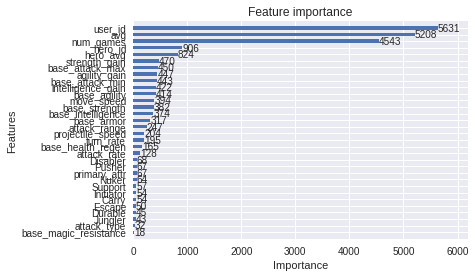

In [34]:
xgb.plot_importance(xgb_model,height=0.5, xlabel='Importance', ylabel='Features')

In [35]:
xgb_model1 = XGBRegressor(n_estimators=1200,
                   max_depth=7,
                   learning_rate=0.2,
                   subsample=0.75,
                   colsample_bytree=0.83,
                   gamma=0.09,
                   seed=7
                  )

xgb_model1.fit(X_train, np.log(1+y_train))

pred1 = xgb_model1.predict(X_train)
pred2 = xgb_model1.predict(X_valid)
print('Training error :',math.sqrt(mean_squared_error(y_train, np.exp(pred1))))
print('Validation error :',math.sqrt(mean_squared_error(y_valid, np.exp(pred2))))

Training error : 364.3244615893699
Validation error : 453.72497151335745


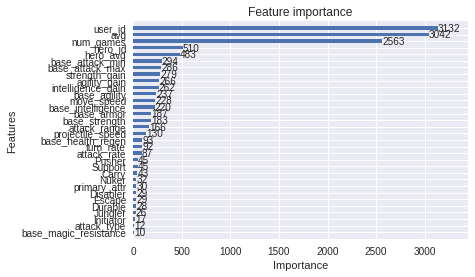

In [36]:
xgb.plot_importance(xgb_model1,height=0.5, xlabel='Importance', ylabel='Features')

In [37]:
submission = pd.read_csv('sample_submission_CKEH6IJ.csv')

In [38]:
pred1 = xgb_model.predict(X_test)
pred2 = xgb_model1.predict(X_test)

In [39]:
pred3 = xgb_model.predict(X_valid)
pred4 = xgb_model1.predict(X_valid)
print("validation error :" , math.sqrt(mean_squared_error(y_valid, (0.5*np.exp(pred3) + 0.5*np.exp(pred4)))))

validation error : 425.55354987345896


In [40]:
submission['kda_ratio'] = (np.exp(pred1) + np.exp(pred2))/2

In [41]:
submission.head()

,id,kda_ratio
0,3_53,2518.925293
1,4_17,3310.660645
2,9_51,2798.226562
3,10_54,4633.034180
4,15_74,4874.923828


In [42]:
submission.to_csv('Hawkeye.csv', index=False)